## Programming Assignment 2 - Solving sudoku in quantum

In this assignment, we will look at how to use Grover's algorithm to solve a real world problem.

Disclaimer : Recall from Lab 1 that we saw how to create and run jupyter (.ipynb) notebooks using IBM Quantum Lab. For this assignment, please continue using the same to avoid any installation issues.\
You can upload and download notebooks in IBM Quantum Lab.

Fill in your details in the below cell. \
Your Name :  Abhinav Sapra
ID : MCS202301

Rename the notebook with your ID as a suffix before submitting in the moodle page.

## Problem Statement 

Consider a 2×2 binary sudoku, with two simple rules:
* No column may contain the same value twice
* No row may contain the same value twice

Assigning each square in the sudoku to a variable: Construct a quantum circuit to output the solution for this sudoku.
<div align="center">

| __v0__ | __v1__ |
| :---: | :---: | 
| __v2__ | __v3__ |

</div>

Mathematically, we simply need solve a boolean function that checks whether the state of our variable bits is a valid solution. Since we need to check down both columns and across both rows, there are 4 constraints all of which need to be satisfied:

* v0 ≠ v1   # check along top row
* v2 ≠ v3   # check along bottom row
* v0 ≠ v2   # check down left column
* v1 ≠ v3   # check down right column

## Expected output

Set of assignments to the binary variables v0,v1,v2 and v3 such that the above conditions are satisfied.

In this assignment, we will try to find such an assignment (or set of assignments if there are more than 1) using Grover's algorithm. 

To help you solve this, the assignment is broken down into individual parts. You need to write the code wherever marked.

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import qiskit.circuit.library
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import Diagonal, ZGate
from qiskit import BasicAer
from qiskit.execute_function import execute
import numpy as np
from math import pi

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

## Create logical gates with the help of quantum gates

### NOT gate

The NOT gate flips the value of a bit and, as was mentioned before, an X gate can be considered a NOT gate. The truth table for a NOT gate looks like this:

| Input | Output |
| --- | --- |
| 1 | 0 |
| 0 | 1 |

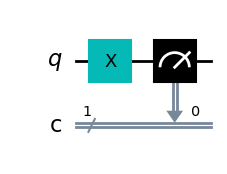

In [2]:
not_gate=QuantumCircuit(1,1) # Create a quantum circuit with 1 qubit and 1 classical bit
not_gate.x(0)
not_gate.measure(0,0)
not_gate.draw(output='mpl')

### AND gate

The output of an AND is true if and only if both inputs are true. The truth table for an AND Gate looks like this:

| A (Input) | B (Input) | Output |
| --- | --- | --- |
| 0 | 0 | 0 | 
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

With a Toffoli gate, we can get the result of an AND gate by interpreting the two control bits as the input bits and the target bit as the output bit.

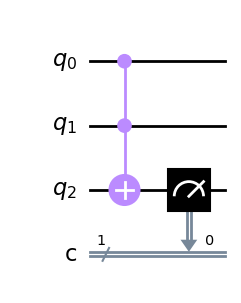

In [3]:
and_gate=QuantumCircuit(3,1) # Create a quantum circuit with 3 qubits and 1 classical bit
and_gate.ccx(0,1,2)
and_gate.measure(2,0)
and_gate.draw(output='mpl')

### OR gate

An OR gate returns true if at least one of the input gates is true.
The truth table for an OR Gate looks like this:

| A (Input) | B (Input) | Output |
| --- | --- | --- |
| 0 | 0 | 0 | 
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

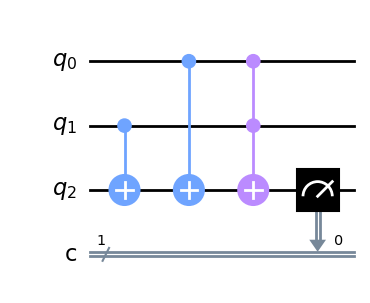

In [4]:
or_gate=QuantumCircuit(3,1) # Create a quantum circuit with 3 qubits and 1 classical bit
or_gate.cx(1,2)
or_gate.cx(0,2)
or_gate.ccx(0,1,2)
or_gate.measure(2,0)
or_gate.draw(output='mpl')

### XOR gate

A XOR gate returns true if both of the inputs are not equal.
The truth table for an XOR Gate looks like this:

| A (Input) | B (Input) | Output |
| --- | --- | --- |
| 0 | 0 | 0 | 
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

Do you see a relation between XOR and the sudoku problem?

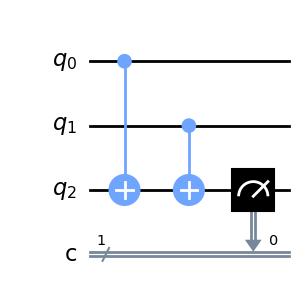

In [5]:
xor_gate=QuantumCircuit(3,1) # Create a quantum circuit with 3 qubits and 1 classical bit
xor_gate.cx(0,2)
xor_gate.cx(1,2)
xor_gate.measure(2,0)
xor_gate.draw(output='mpl')

## Create a quantum circuit that satisfies the boolean constraints of the sudoku problem described above

Hint : A quantum circuit with 9 qubits will work for this, 4 for the variables, 4 to encode truth value of each constraint and one qubit for the output which is a conjunction of the four constraints.

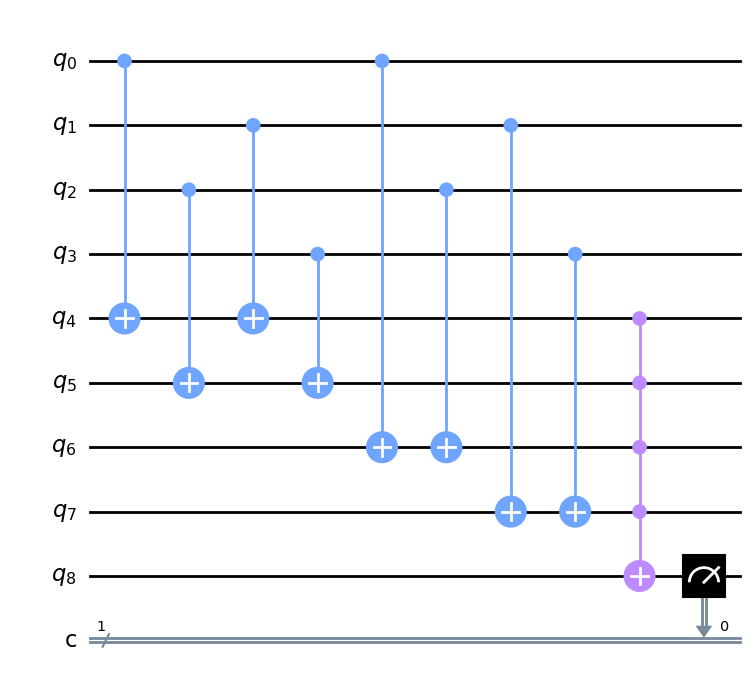

In [6]:
# Write your code here
sudoku = QuantumCircuit(9,1)
sudoku.cx(0,4)
sudoku.cx(1,4)
sudoku.cx(2,5)
sudoku.cx(3,5)
sudoku.cx(0,6)
sudoku.cx(2,6)
sudoku.cx(1,7)
sudoku.cx(3,7)
sudoku.mcx([4,5,6,7],8)
sudoku.measure(8,0)

sudoku.draw(output='mpl')


## Phase Kickback

During the Grover's algorithm, we have seen how the information of the function $f(x)$ is transferred to the sign/phase by considering the output qubit to be in $|-\rangle$ state. \
This trick is usually referred to as "Phase Kickback", where the information of the function is passed back from the output qubit onto the state as phase

## Initialize the output qubit in the above circuit to $|-\rangle$ to realize Phase Kickback

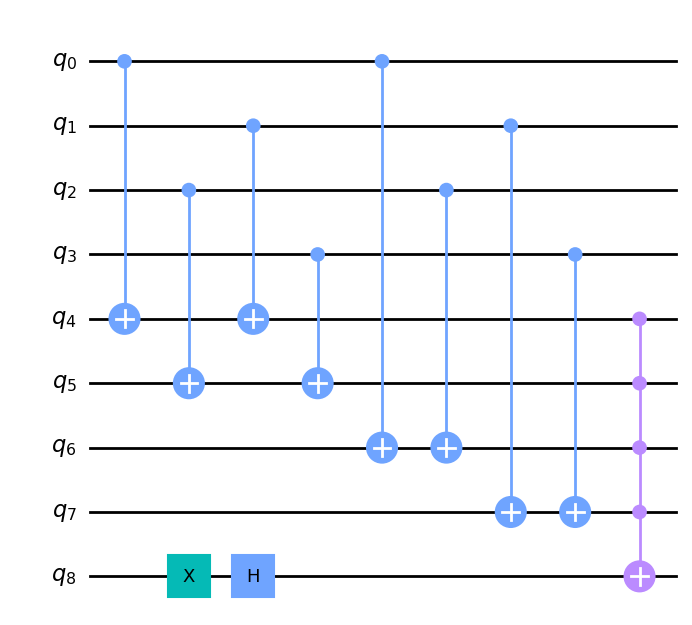

In [7]:
# Write your code here
sudoku = QuantumCircuit(9)

sudoku.cx(0,4)
sudoku.cx(1,4)
sudoku.cx(2,5)
sudoku.cx(3,5)
sudoku.cx(0,6)
sudoku.cx(2,6)
sudoku.cx(1,7)
sudoku.cx(3,7)

sudoku_inverse= QuantumCircuit(9)
sudoku_inverse = sudoku.inverse()

sudoku.x(8)
sudoku.h(8)
sudoku.mcx([4,5,6,7],8)



sudoku.draw(output='mpl')


## Uncomputation

Upon keen observation, the final result we want to find is the assignment to the input variables that satisfy the constraints right? \
Compare this with the usual Grover's algorithm with a black box. We see that in addition to the input qubits (the first 4) and the output qubit (the last qubit) in the usual Grover oracle, we used 3 more qubits to construct the oracle. \
Now, these additional qubits we used for clauses needs to be reversed (or uncomputed) so that the oracle is coherent with the usual Grover's oracle. \
What happens if these are left unchanged?

## Append the Quantum Circuit that uncomputes the values of the clause qubits so that they are taken back to their initial configuration i.e., $|0000\rangle$

Hint : Every unitary is invertible

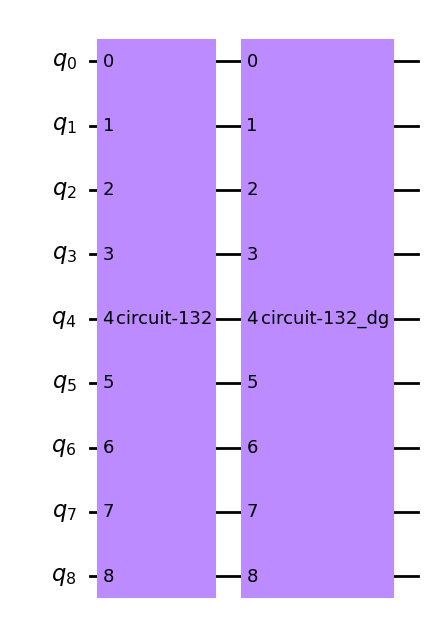

In [8]:
# Write your code here

answer=QuantumCircuit(9)
answer.append(sudoku,[i for  i in range(9)])
answer.append(sudoku_inverse,[i for  i in range(9)])
answer.draw(output='mpl')


## Diffuser operator

One of the key operators used in Grover's algorithm is the construction of the Diffuser operator. Recall that the diffuser operator has the following structure

$$G = I-2|\psi\rangle\langle\psi|$$

where $|\psi\rangle$ is a uniform superposition on the possible assignments which in our case all possible binary strings of length 4

Hints : 
* Recall that $G$ can be re-written as $$G = H^{\otimes n} (I-|0\rangle\langle 0|) H^{\otimes n}$$
* Use phase kickback idea for the middle part

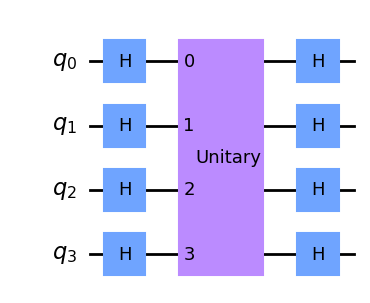

In [9]:
# Write a code to construct the diffuser operator for the problem
import numpy as np
diff_op = QuantumCircuit(4)
for i in range(4):
    diff_op.h(i)

dag = [1]*16
dag[0] = -1

matrix = Operator(Diagonal(dag))

diff_op.append(matrix,[i for i in range(4)])

for i in range(4):
    diff_op.h(i)

diff_op.draw()

## Putting it altogether

With all the pieces in place, we are finally ready to solve for the satisfying assignment using Grover's algorithm. 

Assemble the oracle circuit and the diffuser and repeat them for $\lfloor \frac{\pi}{4}.\sqrt{N}\rfloor$ times which would be the final circuit where recall that $N$ is the total number of possible assignments

Don't forget to measure the assignment qubits (the first 4 qubits) at the end 😉



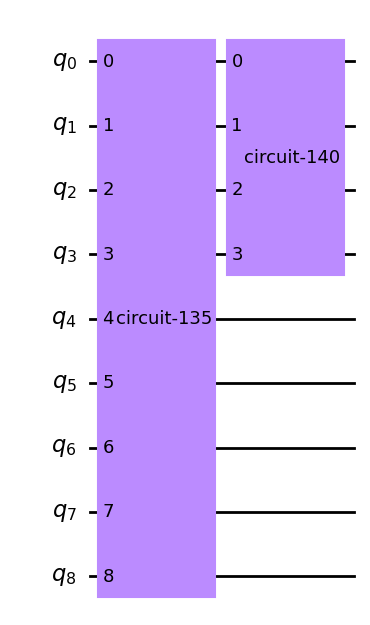

In [10]:
# Write your code here to put all the pieces together as a single circuit
final_cir = QuantumCircuit(9)

final_cir.append(answer,[i for i in range(9)])
final_cir.append(diff_op,[i for i in range(4)])

final_cir.draw()

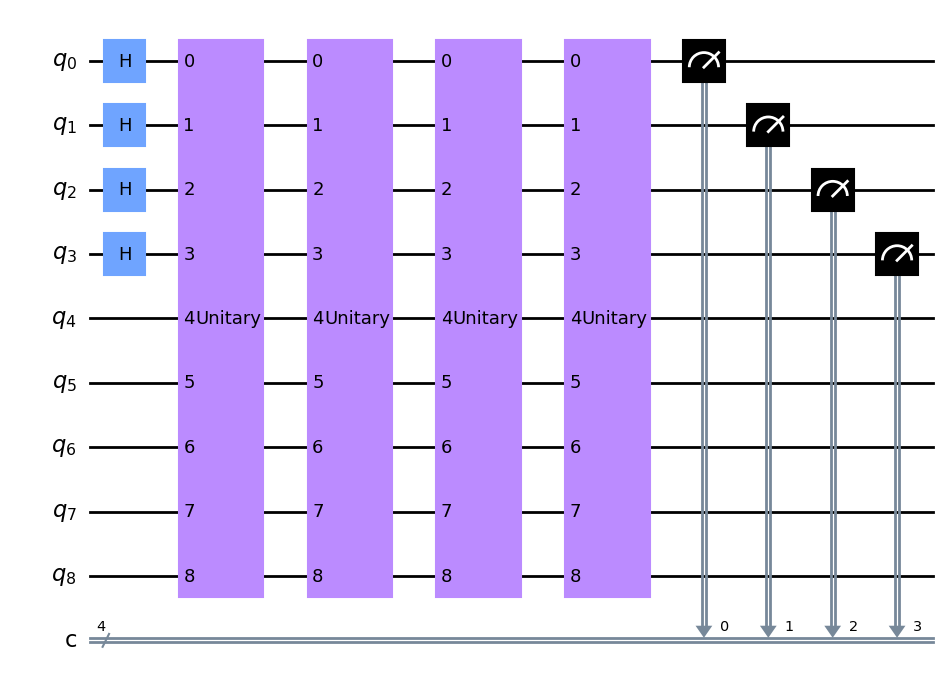

In [11]:
#we make the main circuit
main_circ = QuantumCircuit(9,4)
for i in range(4):
    main_circ.h(i)
for i in range(4):
    main_circ.append(Operator(final_cir),[i for i in range(9)])
    
for i in range(4):
    main_circ.measure(i,i)
main_circ.draw()

## Simulate using Aer Simulator

Now, since we have the circuit lets first perform an ideal simulation to find out if there are any satisfying assignment to our problem

{'0010': 412, '0110': 1947, '1110': 475, '0100': 422, '0101': 417, '1011': 431, '0001': 406, '0011': 414, '1001': 1932, '1010': 458, '0000': 441, '1100': 499, '0111': 404, '1111': 415, '1000': 448, '1101': 479}


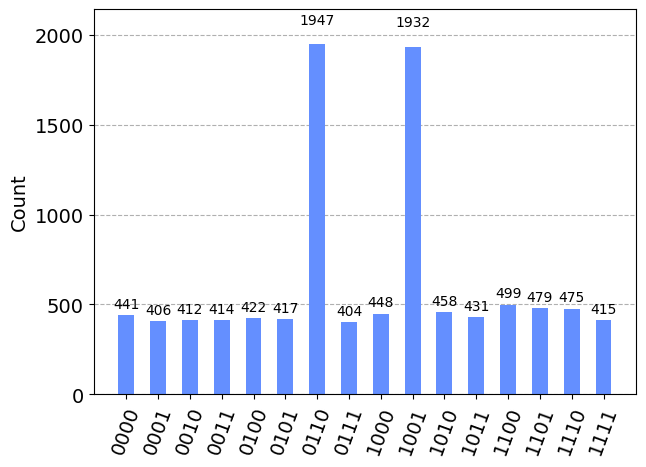

In [13]:
# Write a code to run the final circuit and plot the results to see if there are any satisfying assignments
backend = BasicAer.get_backend('qasm_simulator')
job = execute(main_circ, backend, shots = 10000)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

# List down the satisfying assignments and verify for yourself if they are correct
we notice that the satisfying assingments to the sudoku are :
    {v_1=0,v_2=1,v_3=1,v_4=0}
    {v_1=1,v_2=0,v_3=0,v_4=1}


## Noisy simulation

Let's now use our knowledge of transpilation and noisy simulations to see what the results may look like on a noisy backend.

Plot the result while running the above circuit on two fake backends
1. FakeGuadalupe (16 qubits)
2. FakeKolkata (27 qubits)

In [14]:
# Write your code here
from qiskit.providers.aer import noise

In [15]:
from qiskit.providers.fake_provider import FakeKolkata

In [ ]:
backend = FakeKolkata()
job = execute(init, backend, shots = 1)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## Optional : Optimizations

Explore how the results change with different optimizations we discussed during transpilation lecture.

In [ ]:
# Write your code here

**Credits: Similar exerise was carried out during the ACM Winter School at IIT Madras, December 2022**

### Resources for more advanced problem

https://www.classiq.io/insights/competition-results-kakuro